# Hough transform: initial implementation

This notebook contains the initial implementation of the Hough transform to detect straight lines in skeletonised microtubule images. The transform works well with one and multiple lines. There is a brief comparison to linear regression as another method of detecting straight lines. The main limitationa at this stage are: 
- not using raw data to detect the images;
- detecting lines when there is noise in the sekeletonised images;
- detecting multiple lines which are close together (depends on `max_dist` parameter of local maxima detection algorithm).

### Read in data

In [58]:
# import packages 
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from skimage.feature import peak_local_max
#from toolz import pipe

In [2]:
# paths and filenames 
path = os.getcwd()
path_images = path + "\\test_images\\"
file_names = os.listdir(path_images)
print("Total files in dir: {0}".format(len(file_names)))

Total files in dir: 5


In [46]:
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[0], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))

Total slices in stack: 8


### Pick a skeletonised slice 

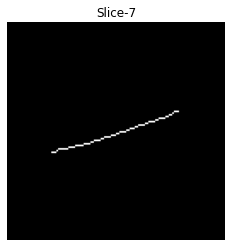

In [47]:
# working wth the seventh slice of this image
img = image[6]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Slice-7");

### Hough transform

A straight line parametrised with polar coordinates becomes:  
$$y = \frac{-\cos(\theta)}{\sin(\theta)} x + \frac{\rho}{\sin(\theta)}$$ 
since  
$$\rho = x\ \cos(\theta) + y\ \sin(\theta)$$

In [71]:
def hough_transform(img): 
    # initialise parameter space of all rhos and thetas
    n_y, n_x = img.shape[:]
    diag = int(np.sqrt(n_x**2 + n_y**2))
    
    # rhos range from -diagnoal to +diagonal of image 
    rhos = np.linspace(-diag, diag, 2*diag+1)
    n_rhos = len(rhos)
    # thetas range from [0, pi] or [-90, 90] radians
    thetas = np.deg2rad(np.linspace(0, 180, 180+1))
    n_thetas = len(thetas)

    # loop through line pixels 
    ### if image is binarised:
    nonzeros = np.argwhere(img==255)
    
    # Hough transform: get rho results 
    x = np.array(nonzeros[:,1])
    y = np.array(nonzeros[:,0])
    n_xys = nonzeros.shape[0]

    theta_mult = np.tile(thetas, n_xys).reshape((n_xys, n_thetas))
    cos_theta_mat = np.cos(theta_mult)
    sin_theta_mat = np.sin(theta_mult)
    rhos_res = (x.reshape(n_xys,1)*cos_theta_mat) + (y.reshape(n_xys,1)*sin_theta_mat)
    
    # get frequency of each (theta, rho) pair 
    # theta == theta_vals and rho == rho_vals 
    accumulator, theta_vals, rho_vals = np.histogram2d(
        np.tile(thetas, rhos_res.shape[0]),
        rhos_res.ravel(), 
        bins = [n_thetas-1, n_rhos-1], 
        range = [np.deg2rad([0, 180]), [-diag, diag]])
    
    return accumulator, theta_vals, rho_vals

In [72]:
accumulator, theta_vals, rho_vals = hough_transform(img)

### Detecting a single, longest line

In [50]:
# detect the longest line in the image
# (which would have the highest number of intersecting curves in Hough space)
def conv_via_max(accumulator, theta_vals, rho_vals): 
    # index of maximum in accumulator
    ind = np.argwhere(accumulator==np.max(accumulator))[0]
    
    # get coordinates of line in cartesian coordinates
    rho_f = rho_vals[ind[1]]
    theta_f = theta_vals[ind[0]]
    cos_theta_f = np.cos(theta_f)
    sin_theta_f = np.sin(theta_f)
    
    n_x = 128 # assumes 128x128 image
    xs = np.linspace(0, n_x-1, n_x) 

    intercept = rho_f/sin_theta_f
    slope = -cos_theta_f / sin_theta_f
    slope_x = np.array([(-cos_theta_f*xs)/sin_theta_f])

    ys = slope_x + intercept
    
    return xs, ys, ind, slope, intercept

In [51]:
xs, ys, ind, slope, intercept = conv_via_max(accumulator, theta_vals, rho_vals)

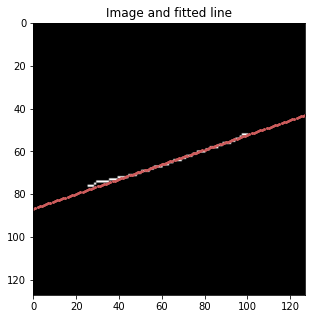

In [52]:
# overlay image with fitted line 
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
x = np.array(img.shape[0])
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.title("Image and fitted line")
plt.show()

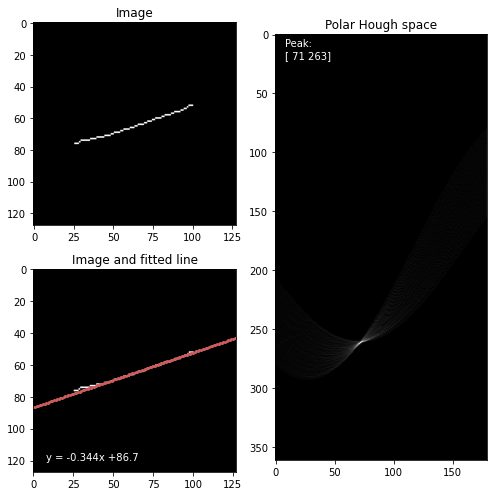

In [62]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(slope, 3)) + "x +" + str(np.round(intercept, 1))),
         fontsize = 10, color = "white")
plt.title("Image and fitted line")

fig.add_subplot(122)
#plt.figure(figsize=(5,7))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.title("Polar Hough space");
plt.text(8, 20,("Peak:\n"+str(ind)),
         fontsize = 10, color = "white");

plt.tight_layout()
#plt.savefig("figs\\image_fit_overlay_hough.png", format="png", dpi=600)

In [64]:
print("m = ", np.round(slope, 3), "    intercept = ", np.round(intercept, 1))

m =  -0.344     intercept =  86.7


### Compare Hough transform to linear regression

In [59]:
nonzeros = np.argwhere(img==255)
X = np.array(nonzeros[:,1]).reshape((-1,1))
Y = np.array(nonzeros[:,0])

In [65]:
model = LinearRegression().fit(X, Y)
print("R squared: ", np.round(model.score(X, Y), 4)) 
y_LR = model.predict(xs.reshape((-1, 1)))

R squared:  0.9915


In [66]:
# compare two fits
print("Hough transform:      m = ", np.round(slope, 3), 
      "    inteercept = ", np.round(intercept, 1))
print("Linear regression:    m = ", np.round(model.coef_[0], 3),
      "    inteercept = ", np.round(model.intercept_, 1))

Hough transform:      m =  -0.344     inteercept =  86.7
Linear regression:    m =  -0.324     inteercept =  85.4


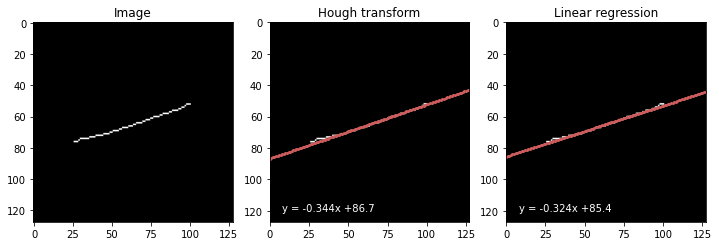

In [69]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(10, 4))

# image 
fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

# Hough transform result 
fig.add_subplot(1, 3, 2)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(slope, 3)) + "x +" + str(np.round(intercept, 1))),
         fontsize = 10, color = "white")
plt.title("Hough transform")

fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, y_LR, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(model.coef_[0], 3)) + "x +" + str(np.round(model.intercept_, 1))),
         fontsize = 10, color = "white")
plt.title("Linear regression")

plt.tight_layout()
#plt.savefig("figs\\Hough_transform_vs_Linear_regression.png", format="png", dpi=600)

There is a slight (and practically negligible) difference in the deteceted lines.  Whereas linear regression minimises the square of all residuals, the Hough transform gives more weight to points which lie on the same straight line (which result in more intersecting curves in Hough space and a more incremented accumulator). Linear regression would not be able to handle vertical lines. 

### Detect multiple lines using local maxima detection algorithm

Total slices in stack: 4


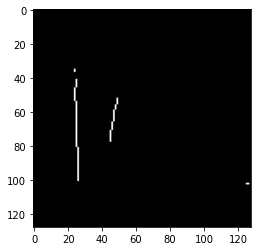

In [101]:
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[4], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))
img = image[0]
plt.imshow(img, cmap="gray");
plt.axis("off");

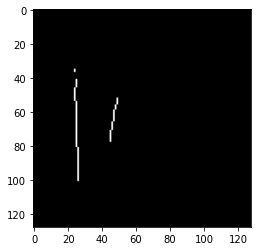

In [140]:
# rmove noise if necessary
nonzeros = np.argwhere(img==255)
img[100:, 110:130] = 0
plt.imshow(img, cmap="gray");
#img = np.transpose(img)

In [153]:
def conv_via_locmax(accumulator, theta_vals, rho_vals, min_dist = 20):
    # find local maxima 
    peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = False)
    n_peaks = peaks.shape[0]
    print(n_peaks, "peaks:")
    if n_peaks<10: print(peaks)
    
    n_x = 128
    xs = np.linspace(0, n_x-1, n_x)
    # get coordinates of line in cartesian coordinates
    rho_peaks = rho_vals[peaks[:,1]]
    theta_peaks = theta_vals[peaks[:,0]]

    cos_theta_peaks = np.cos(theta_peaks)
    sin_theta_peaks = np.sin(theta_peaks)
    # avoid sin(theta = 0) = 0 // can't divide by 0 
    sin_theta_peaks = np.where(sin_theta_peaks == 0, 0.0001, sin_theta_peaks)

    intercept = rho_peaks/sin_theta_peaks
    slope = (-cos_theta_peaks) / sin_theta_peaks
    slope_x = -cos_theta_peaks*np.tile(xs.reshape(n_x, 1), n_peaks) / sin_theta_peaks 
    ys = slope_x + intercept
    
    return xs, ys, peaks, [slope, intercept]

In [172]:
accumulator, theta_vals, rho_vals = hough_transform(img)
xs, ys, peaks, params = conv_via_locmax(accumulator, theta_vals, rho_vals, 28)

4 peaks:
[[179 156]
 [  0 206]
 [ 10 238]
 [119 223]]


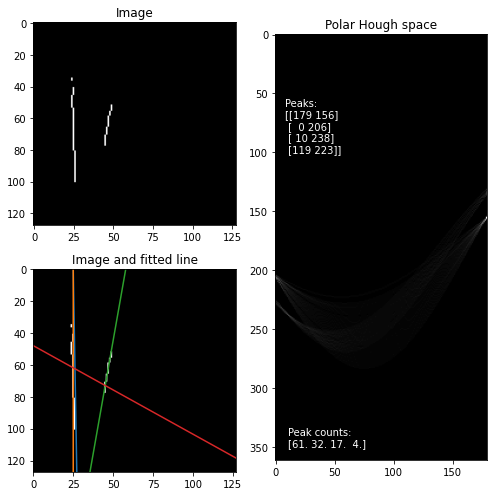

In [173]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.imshow(img, cmap="gray")
n_y, n_x = img.shape[:]
x = np.array(range(n_x))
#for i in range(peaks.shape[0]):
#    plt.plot(xs, ys[:,i], c="indianred")
plt.plot(xs, ys)
plt.xlim(0,n_x-1)
plt.ylim(n_y-1,0)
plt.title("Image and fitted line");

fig.add_subplot(122)
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.text(8, 100,("Peaks:\n"+str(peaks)),
         fontsize = 10, color = "white")
plt.text(10, 350,("Peak counts:\n"+str(accumulator[peaks[:,0], peaks[:,1]])),
         fontsize = 10, color = "white")

plt.title("Polar Hough space");

plt.tight_layout()
#plt.savefig("figs\\image_fit_overlay_hough.png", format="png", dpi=600)

Deciding on a suitable `max_dist` parameter for `peak_local_max()` is challenging, as $\theta$ and $\rho$ are anisotropic and specify different distances... This is further explored in other files. <br>
For example, compare the number of peaks and their counts with `max_dist = 28 and 30`.